In [1]:
import cv2
import math
import copy
import numpy as np
from skimage import measure
from scipy.interpolate import splprep, splev
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy.integrate import simps
from skimage import filters, morphology

### 1. Load the chromophobe-renal-cell-carcinoma image

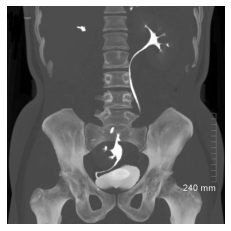

In [2]:
renalcell_img = cv2.imread('chromophobe-renal-cell-carcinoma-6.jpg', 0)
## disable x & y axis
plt.axis('off')
plt.imshow(renalcell_img, cmap='gray', vmin=renalcell_img.min(), vmax=renalcell_img.max())

### 2. Design an interface to obtain the initial contour from user's clicks

In [3]:
renalcell_points = []  
renalcell_img_copy = copy.deepcopy(renalcell_img)

In [4]:
def mouse_click(event, x, y, flags, params):
    # Check whether left mouse button was clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(params[0], (x, y), 5, (255, 0, 0), -1)
        cv2.imshow(params[1], params[0])
        params[2].append([x, y])
        print(params[2])

In [5]:
cv2.namedWindow('Renal Cell Image')
cv2.setMouseCallback('Renal Cell Image', mouse_click, (renalcell_img_copy, 'Renal Cell Image', renalcell_points))

### Press q when you are done with locating the points of the initial contour

In [6]:
while True:
    cv2.imshow('Renal Cell Image', renalcell_img_copy)
    # cv2.waitKey(1)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Press 'q' to exit
        break
    
cv2.destroyAllWindows()
    

[[276, 68]]
[[276, 68], [274, 107]]
[[276, 68], [274, 107], [297, 128]]
[[276, 68], [274, 107], [297, 128], [351, 161]]
[[276, 68], [274, 107], [297, 128], [351, 161], [369, 109]]
[[276, 68], [274, 107], [297, 128], [351, 161], [369, 109], [369, 66]]
[[276, 68], [274, 107], [297, 128], [351, 161], [369, 109], [369, 66], [317, 65]]


In [7]:
renalcell_points = np.array(renalcell_points)
renalcell_points

array([[276,  68],
       [274, 107],
       [297, 128],
       [351, 161],
       [369, 109],
       [369,  66],
       [317,  65]])

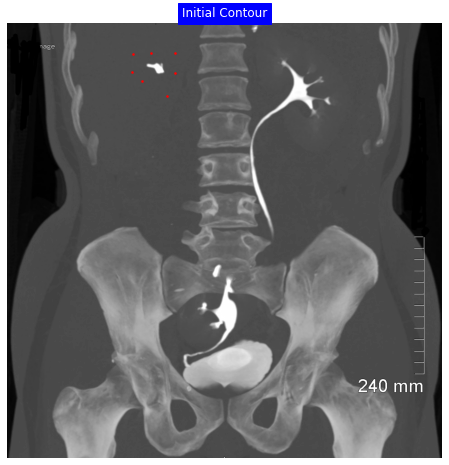

In [8]:
fig, ax = plt.subplots(figsize=(18, 8))
## disable x & y axis
ax.axis('off')
plt.title('Initial Contour', color='white', backgroundcolor='blue')
ax.imshow(renalcell_img, cmap='gray')
ax.scatter(renalcell_points[:, 0], renalcell_points[:, 1], marker=".", color="red", s=10)
plt.show()

### Convert the initial contour points located by user, to a set of 2D points that are equally spaced along the object's contour.

In [9]:
def equally_spaced_boundary_pts(initial_points, pt_spacing=10):
    # interpolate boundary
    tck, u = splprep(initial_points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, der=0)

    # get equi-spaced points along spline-interpolated boundary
    x_diff, y_diff = np.diff(x_new), np.diff(y_new)
    S = simps(np.sqrt(x_diff**2 + y_diff**2))
    N = int(round(S/pt_spacing))

    u_equidist = np.linspace(0, 1, N+1)
    x_equidist, y_equidist = splev(u_equidist, tck, der=0)
    return np.array(list(zip(x_equidist, y_equidist)))

In [10]:
boundary_pts = equally_spaced_boundary_pts(renalcell_points, pt_spacing=5)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][7]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][7]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


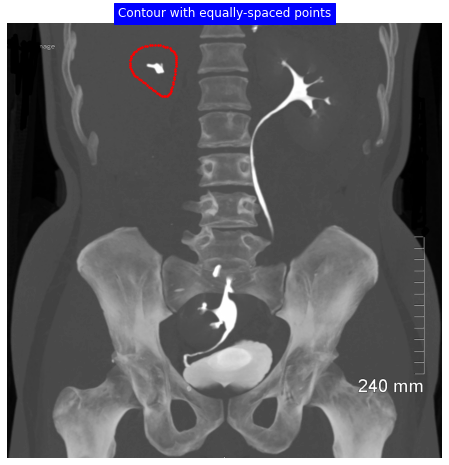

In [11]:
fig, ax = plt.subplots(figsize=(18, 8))
## disable x & y axis
ax.axis('off')
plt.title('Contour with equally-spaced points', color='white', backgroundcolor='blue')
ax.imshow(renalcell_img, cmap='gray')
ax.scatter(boundary_pts[:, 0], boundary_pts[:, 1], marker=".", color="red", s=10)
plt.show()

### 3. Compute the external energy by maximizing the energy near the edges

In [12]:
def detect_edges(image):
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Perform Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    return edges

In [13]:
## Compute Snake external energy using the "distance from edge" approach
edges = detect_edges(renalcell_img)
thresh = filters.threshold_otsu(edges)
prominent_ridges = edges > 0.8*thresh
skeleton = morphology.skeletonize(prominent_ridges)
edge_dist = ndimage.distance_transform_edt(~skeleton)
edge_dist = filters.gaussian(edge_dist, sigma=2)

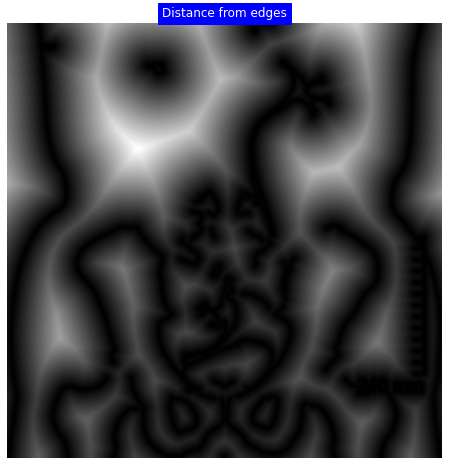

In [14]:
fig, ax = plt.subplots(figsize=(18, 8))
## disable x & y axis
ax.axis('off')
plt.title('Distance from edges', color='white', backgroundcolor='blue')
ax.imshow(edge_dist, cmap='gray')

### 4. Define main function to calculate total energy and move the contour accordingly

In [15]:
def active_contour(initial_contour, edge_dist, num_iterations, alpha, beta, gamma):
    height, width = edge_dist.shape[:2]
    pts = initial_contour

    # Iteratively update the contour
    for _ in range(num_iterations):
        # External energy
        external_energy = edge_dist

        # Internal energy
        ## Spacing energy (favors equi-distant points)
        prev_pts = np.roll(pts, 1, axis=0)
        next_pts = np.roll(pts, -1, axis=0)
        displacements = pts - prev_pts
        point_distances = np.sqrt(displacements[:,0]**2 + displacements[:,1]**2)
        mean_dist = np.mean(point_distances)
        spacing_energy = np.sum((point_distances - mean_dist)**2)

        ## Curvature energy (favors smooth curves)
        curvature_1d = prev_pts - 2*pts + next_pts
        curvature = (curvature_1d[:,0]**2 + curvature_1d[:,1]**2)
        curvature_energy = np.sum(curvature)
        
        # Total energy
        total_energy = alpha*spacing_energy + beta*curvature_energy - gamma*external_energy

        # Calculate the gradient of the total energy
        gradient_x = cv2.Sobel(total_energy, cv2.CV_64F, 1, 0, ksize=3)
        gradient_y = cv2.Sobel(total_energy, cv2.CV_64F, 0, 1, ksize=3)

        # Update the contour using the gradient
        updated_contour = pts.copy()
        for i in range(pts.shape[0]):
            x, y = pts[i]

            # Perform boundary checks
            if x < 0:
                x = 0
            elif x >= width:
                x = width - 1
            if y < 0:
                y = 0
            elif y >= height:
                y = height - 1

            dx = gradient_x[int(y), int(x)]
            dy = gradient_y[int(y), int(x)]
            updated_x = x + dx
            updated_y = y + dy

            # Perform boundary checks on the updated points
            if updated_x < 0:
                updated_x = 0
            elif updated_x >= width:
                updated_x = width - 1
            if updated_y < 0:
                updated_y = 0
            elif updated_y >= height:
                updated_y = height - 1

            updated_contour[i] = [updated_x, updated_y]


        # Update the initial contour
        pts = updated_contour.astype(np.int32)

    return pts, total_energy

#### Plot contours after 5, 10, and 20 iterations

In [16]:
final_contour_5it, total_energy_5it = active_contour(boundary_pts, edge_dist, 5, 0.5, 0.4, 0.5)
final_contour_10it, _ = active_contour(boundary_pts, edge_dist, 10, 0.5, 0.4, 0.5)
final_contour_20it, _ = active_contour(boundary_pts, edge_dist, 20, 0.5, 0.4, 0.5)

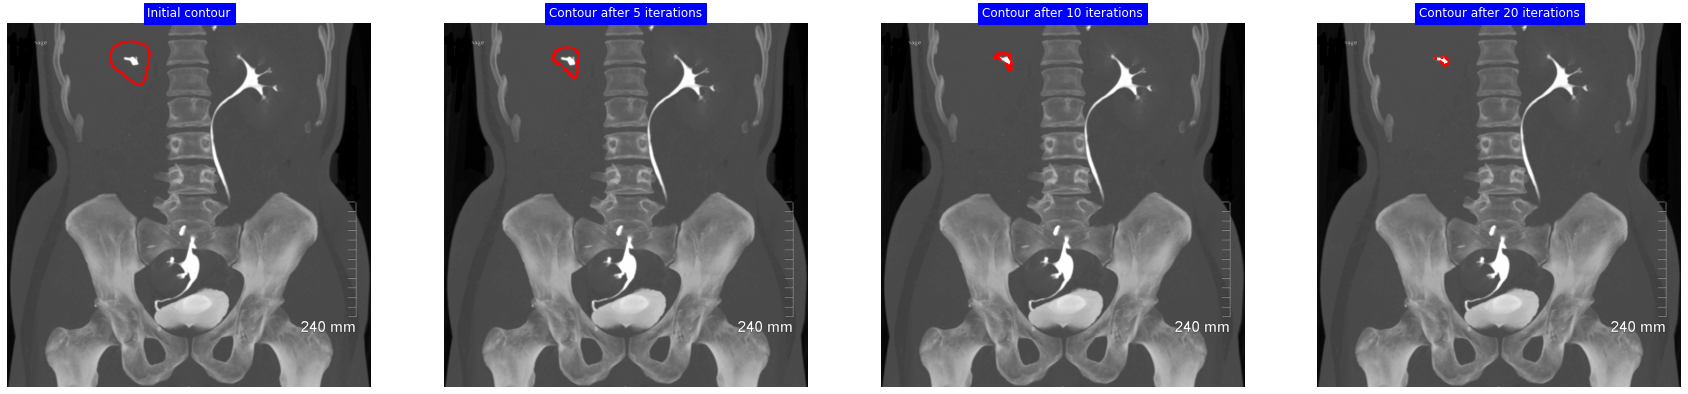

In [17]:
fig = plt.figure(figsize=(30, 15))
gs = fig.add_gridspec(2, 4)

# Initial contour
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
ax1.imshow(renalcell_img, cmap='gray')
ax1.set_title('Initial contour', color='white', backgroundcolor='blue')
ax1.scatter(boundary_pts[:, 0], boundary_pts[:, 1], marker=".", color="red", s=10)

# Contour after 5 iterations
ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')
ax2.imshow(renalcell_img, cmap='gray')
ax2.set_title('Contour after 5 iterations', color='white', backgroundcolor='blue')
ax2.scatter(final_contour_5it[:, 0], final_contour_5it[:, 1], marker=".", color="red", s=10)

# Contour after 10 iterations
ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')
ax3.imshow(renalcell_img, cmap='gray')
ax3.set_title('Contour after 10 iterations', color='white', backgroundcolor='blue')
ax3.scatter(final_contour_10it[:, 0], final_contour_10it[:, 1], marker=".", color="red", s=10)

# Contour after 20 iterations
ax4 = fig.add_subplot(gs[0, 3])
ax4.axis('off')
ax4.imshow(renalcell_img, cmap='gray')
ax4.set_title('Contour after 20 iterations', color='white', backgroundcolor='blue')
ax4.scatter(final_contour_20it[:, 0], final_contour_20it[:, 1], marker=".", color="red", s=10)

plt.show()